# Wines dataset personal project

## Classification Approach

### Structure Description
- Compare Regression Models
- Perform HPO
- Compare Optimized models
- Perform Ensembling

In [57]:
# Load standard libraries
%run libs

# Import my utils
import utils

# Import sklearn modules for data processing, train/test splitting
from sklearn.preprocessing import StandardScaler

# Import sklearn modules for train/test splitting
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold

# Import some Regressors
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# Import some classifiers # List of most classifiers in sklearn: https://stackoverflow.com/questions/41844311/list-of-all-classification-algorithms
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier

# Import SKOPT modules for HPO
from skopt import forest_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt.plots import plot_convergence, plot_evaluations, plot_objective
from skopt import dump, load

# Define random seed for reproducibility of results
seed = 42

# Standard scaler will be used for all models
scaler = StandardScaler()

libraries loaded


In [58]:
# Define functions

def load_best_parameters(model):
    model_name = model.__class__.__name__
    try:
        res = load(r'output/models/'+model_name)
        param_names = res.param_names
        param_values = res.x
        best_pparameters_dict = dict(zip(param_names, param_values))
        model.set_params(**best_pparameters_dict)
        print(model_name, 'optimized parameters:', best_pparameters_dict)  
    except:
        print(model_name, 'parameters were not previously optimized')
    return model


def save_predicts_to_file(model_name, predicts, file_path):
    try:
        df = pd.read_csv(file_path)
        df[model_name] = predicts
        df.to_csv(file_path, index=False)
        print('Model predicts updated in file', file_path)
    except:
        pd.DataFrame(predicts, columns=[model_name]).to_csv(file_path, index=False)
        print('Model predicts saved in file', file_path)


def get_train_test_predicts(model, X_train, y_train, X_test, y_test, seed):
    model_name = model.__class__.__name__
    print(model_name)

    model = load_best_parameters(model)

    pipeline = make_pipeline(scaler, model)
    cv = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)
    y_train_predict = cross_val_predict(pipeline, X_train, y_train, cv=cv, n_jobs=-1)
    train_mse = mse(y_train, y_train_predict)
    print('train mse:', train_mse)
    
    # now train the model on all train data and predict for test
    model.fit(X_train,y_train)
    y_test_predict = model.predict(X_test)
    test_mse = mse(y_test, y_test_predict)
    print('test mse:', test_mse)

    save_predicts_to_file(model_name, y_train_predict, r'output/predicts/1st_level_classifiers_train_predicts.csv')
    save_predicts_to_file(model_name, y_test_predict, r'output/predicts/1st_level_classifiers_test_predicts.csv')
    
    
def plot_shap_feature_importance(model, X, y):
    model = load_best_parameters(model)
    model.fit(X,y)
    shap_values = shap.TreeExplainer(model).shap_values(X)
    try:
        #this should work for classification tasks
        shap.summary_plot(shap_values, X, plot_type='bar', class_names=model.classes_)
    except:
        # this should work for regression tasks
        shap.summary_plot(shap_values, X, plot_type='bar')
    plt.show()


def find_best_hyperparameters(model, X, y, dynamic_params_space, scoring, plot=True, n_splits=5, **HPO_params):
  
    # Get model name
    model_name = model.__class__.__name__
    
    # Get dynamic parameters names: 
    @use_named_args(dynamic_params_space)
    def get_params_names(**dynamic_params):
        return list(dynamic_params.keys())    
    param_names = get_params_names(dynamic_params_space)
        
    # Define an objective function
    @use_named_args(dynamic_params_space)
    def objective(**dynamic_params):
        #model.set_params(**static_params)
        model.set_params(**dynamic_params) 
        pipeline = make_pipeline(scaler, model)
        cv = StratifiedKFold(n_splits=n_splits, random_state=seed, shuffle=True)
        scores = cross_validate(pipeline, X_train, y_train, cv=cv, scoring = scoring, n_jobs=-1)
        val_score = np.mean(scores['test_score'])
        return -val_score
    
    print(model_name, 'model training...')
    # Load previously trained results and get starting point (x0) as best model from previous run
    try:
        res = load(r'output/models/'+model_name)
        x0 = res.x       
    # If not trained before -> no initial point provided
    except:
        x0 = None
    
    res = forest_minimize(objective, dynamic_params_space, x0 = x0, **HPO_params)
    
    # add attribute - parameters names to the res
    res.param_names = param_names

    print('Optimized parameters:    ', res.param_names)
    print('Previous best parameters:', x0)
    print('Current  best parameters:', res.x)
    print('Best score:', -res.fun)
    
    # Saved optimization result  
    dump(res, r'output/models/'+model_name, store_objective=False)
        
    if plot == True:
        plt.figure(figsize=(5,2))
        plot_convergence(res)
        try:
            # plot_objective would not work if only one parameter was searched for
            plot_objective(res)
        except:
            pass
    plt.show()
    
def compare_classifiers(models, X_train, y_train, X_test, y_test, n_splits, load_best_params, show_predicts):
    # With the small amount of data - 2000 points only cross-validation is very important
    # Simple train-test split is not robust in this case and one is better to use KFold CV
    train_scores = []
    val_scores = []
    test_scores = []
    model_names = []
    fit_times = []
    
    # iterate over classifiers
    for model in models:
        
        model_name = model.__class__.__name__
        
        if load_best_params:
            model = load_best_parameters(model)
        
        # We need to use pipeline to make feature scaling for each fold so that
        # scaler.fit is done on train and scaler.predict on test
        pipeline = make_pipeline(scaler, model)
        # Now we just pass pipeline to the CV instead of model
        cv = StratifiedKFold(n_splits=n_splits, random_state=seed, shuffle=True)
        scores = cross_validate(pipeline, X_train, y_train, cv=cv, return_train_score=True, n_jobs=-1)
        
        fit_time = np.mean(scores['fit_time'])        
        train_score = np.mean(scores['train_score']) #np.mean(scores['train_score'])
        val_score = np.mean(scores['test_score']) #np.mean(scores['test_score'])    

        fit_times.append(fit_time)
        model_names.append(model_name)
        train_scores.append(train_score)
        val_scores.append(val_score)   
        
        # Train on all train data, predict for test
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        model.fit(X_train,y_train)
        y_predict_test = model.predict(X_test)
        accuracy_test = accuracy_score(y_test, y_predict_test)
        
        test_scores.append(accuracy_test)
        
        if show_predicts:
            print(model_name)
            print('y_test values        :', np.unique(y_test, return_counts=True)[0], 'counts: ', np.unique(y_test, return_counts=True)[1])
            print('y_test_predict values:', np.unique(np.round(y_predict_test), return_counts=True)[0], 'counts:', np.unique(np.round(y_predict_test), return_counts=True)[1])

    results = pd.DataFrame(list(zip(model_names, train_scores, val_scores, test_scores, fit_times)), columns=['model','train_score','val_score', 'test_score', 'fit_time'])
    results = results.sort_values(by=['test_score'], ascending = False)
    results = results.reset_index(drop = True)
    return results

## Load Data

In [62]:
X_train = pd.read_pickle(r'output/data/X_train.pkl')
y_train = pd.read_pickle(r'output/data/y_train.pkl')
X_test  = pd.read_pickle(r'output/data/X_test.pkl')
y_test  = pd.read_pickle(r'output/data/y_test.pkl')

## Classification Task

In [63]:
classifiers = [DummyClassifier(strategy='most_frequent', random_state=0),
               LogisticRegression(max_iter=10000),                             
               GaussianProcessClassifier(1.0 * RBF(1.0)),               
               SVC(kernel="rbf"),    
               KNeighborsClassifier(),               
               MLPClassifier(max_iter=1000),               
               RandomForestClassifier(),
               ExtraTreesClassifier(),
               AdaBoostClassifier(),
               GradientBoostingClassifier(),
               LGBMClassifier()]

## Classification Toy Example

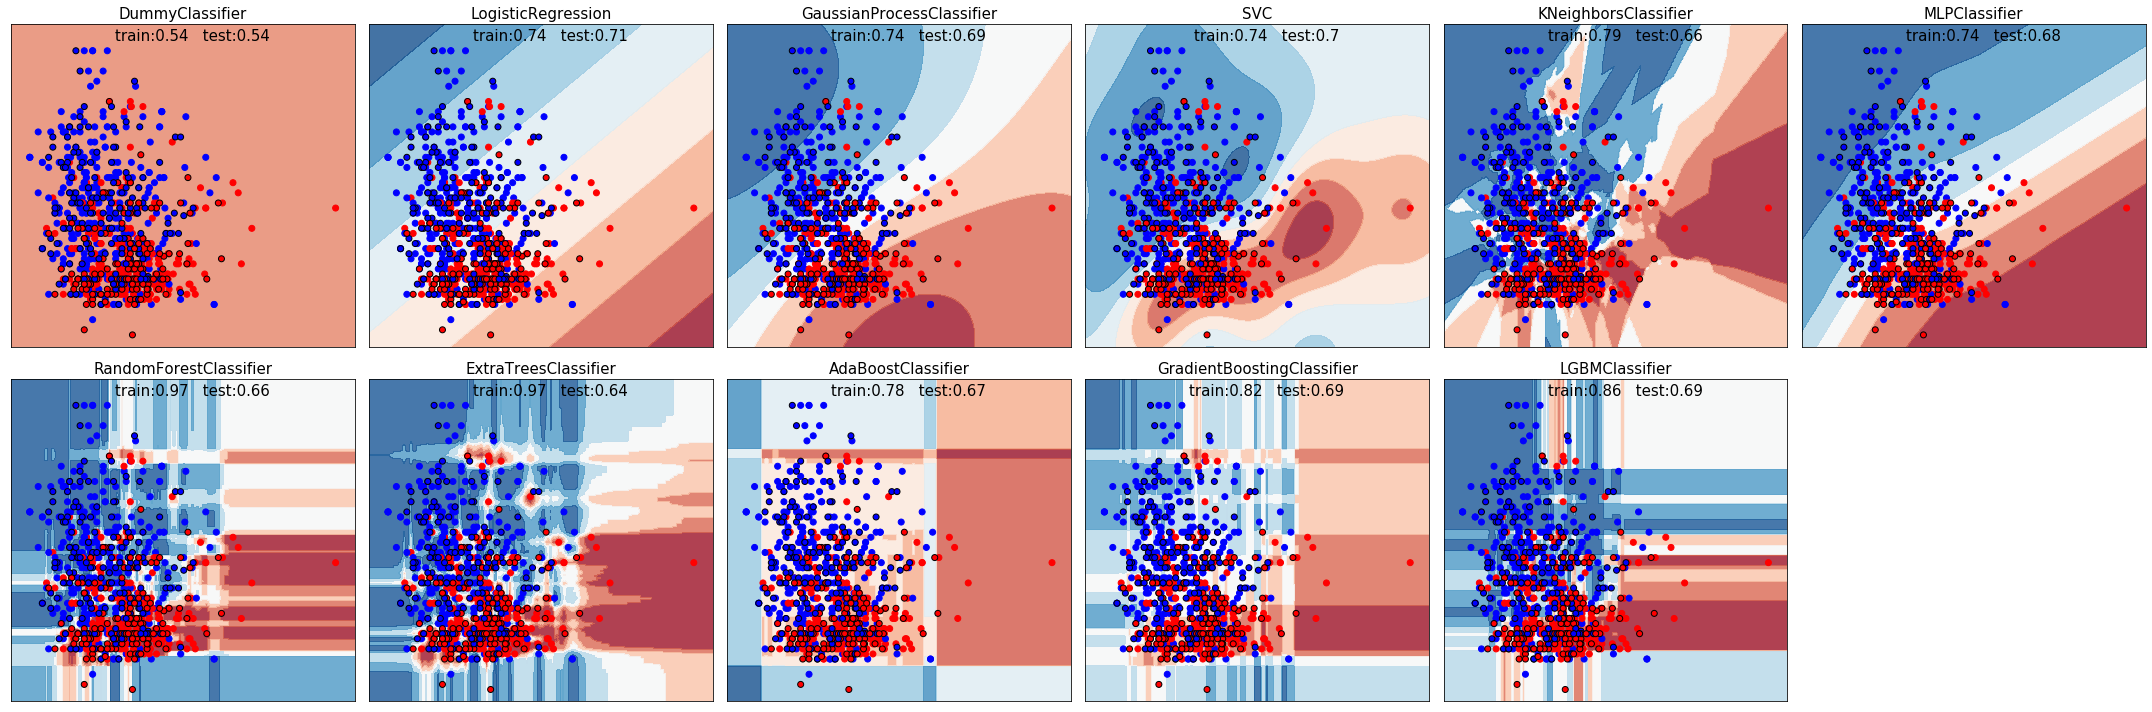

In [14]:
# Let's see how different classifiers perform on the data
from matplotlib.colors import ListedColormap

# We'll use just two features for better visualization
X_ = X_train[['volatile acidity', 'alcohol']].copy()
y_ = y_train.copy()

# For better visualisation change task to binary classification (change label == 3 to 2)
# Now we have just two labels 1 and 2
y_[y_ < 6] = 0
y_[y_>=6] = 1

X_train_, X_test_, y_train_, y_test_ = train_test_split(X_, y_, test_size=0.33, shuffle = True, random_state=42)
X_train_ = scaler.fit_transform(X_train_)
X_test_ = scaler.transform(X_test_)


# Let's compare different classifiers. This version is adapted from: https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

# Build a figure with subplots
fig_size = 5
fig_nrows = 2

fig_ncols = -(-len(classifiers)//fig_nrows) # rounded_up = -(-numerator // denominator)

figure = plt.figure(figsize=(fig_size*fig_ncols, fig_size*fig_nrows))
# Define colors
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
# create mesh
x_min, x_max = X_train_[:, 0].min() - .5, X_train_[:, 0].max() + .5
y_min, y_max = X_train_[:, 1].min() - .5, X_train_[:, 1].max() + .5
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# iterate over classifiers
for idx, model in enumerate(classifiers):
    model_name = model.__class__.__name__
    ax = plt.subplot(fig_nrows, fig_ncols, idx+1) 
    model.fit(X_train_, y_train_)
    train_score = model.score(X_train_, y_train_)
    test_score = model.score(X_test_, y_test_)

    # Plot the decision boundary. For that, we will assign a color to each point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(model, "decision_function"):
        Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

    # Plot the training points
    ax.scatter(X_train_[:, 0], X_train_[:, 1], c=y_train_, cmap=cm_bright, edgecolors=None)
    # Plot the testing points
    ax.scatter(X_test_[:, 0], X_test_[:, 1], c=y_test_, cmap=cm_bright, edgecolors='k')

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(model_name, size=15)
    text = 'train:' + str(np.round(train_score,2)) + '   test:' + str(round(test_score,2))
    ax.text(2, yy.max()-0.3, text, horizontalalignment='center', size=15)

plt.tight_layout()
plt.show()

## Compare Classifiers
Using all features now

In [15]:
compare_classifiers(classifiers, X_train, y_train, X_test, y_test, n_splits=5, load_best_params=False, show_predicts=False)

Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.


,model,train_score,val_score,test_score,fit_time
0,RandomForestClassifier,1.000000,0.632159,0.673239,0.416980
1,LGBMClassifier,1.000000,0.594979,0.650704,0.936887
2,GradientBoostingClassifier,0.954440,0.593931,0.649296,1.754589
3,ExtraTreesClassifier,1.000000,0.638907,0.647887,0.262422
4,SVC,0.681384,0.600667,0.622535,0.037481
5,GaussianProcessClassifier,0.670417,0.586034,0.616901,84.826272
6,LogisticRegression,0.596739,0.578176,0.614085,0.073216
7,MLPClassifier,0.923790,0.572551,0.602817,6.717480
8,AdaBoostClassifier,0.558216,0.535441,0.547887,0.152037
9,KNeighborsClassifier,0.690098,0.553399,0.546479,0.000000


## HPO

LogisticRegression model training...


The objective has been evaluated at this point before.


Optimized parameters:     ['C']
Previous best parameters: [0.4278743516759832]
Current  best parameters: [0.07052965402859755]
Best score: 0.583806259125246


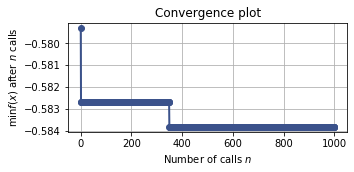

Wall time: 5min 15s


In [16]:
%%time

model = LogisticRegression(max_iter=10000)

dynamic_params_space  = [Real(1e-6, 1, prior='log-uniform', name='C')]

HPO_params = {'n_calls': 1000, 'n_random_starts': 50, 'random_state': 42}
find_best_hyperparameters(model, X_train, y_train, dynamic_params_space, scoring = 'accuracy', plot = True, **HPO_params)

SVC model training...


The objective has been evaluated at this point before.


Optimized parameters:     ['C', 'gamma']
Previous best parameters: [1.6435051877348372, 1.168082234284984]
Current  best parameters: [1.6237306762366168, 1.1766027095650582]
Best score: 0.6265219323303498


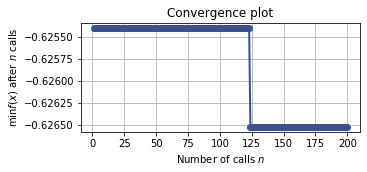

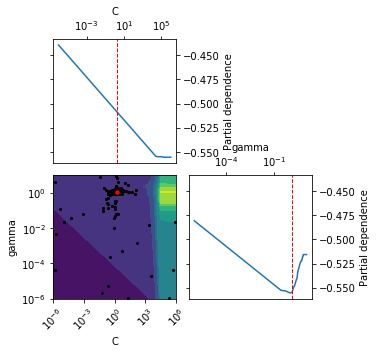

Wall time: 1min 47s


In [17]:
%%time

model = SVC(kernel = 'rbf')

dynamic_params_space  = [Real(1e-6, 1e+6, prior='log-uniform', name='C'),
                         Real(1e-6, 1e+1, prior='log-uniform', name='gamma')]

HPO_params = {'n_calls': 200, 'n_random_starts': 20, 'random_state': 42}
find_best_hyperparameters(model,  X_train, y_train, dynamic_params_space, scoring = 'accuracy', plot = True, **HPO_params)

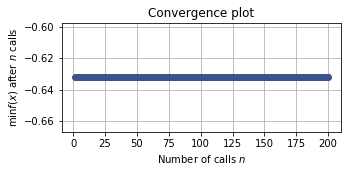

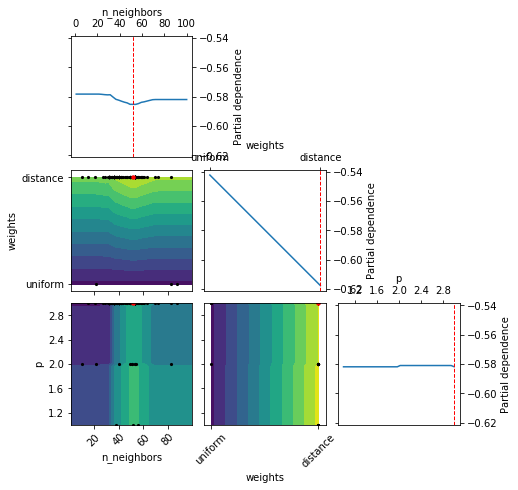

In [18]:
%%capture --no-display 
# use capture to capture error messages that the function evaluated at the same point

model = KNeighborsClassifier()

dynamic_params_space  = [Integer(1, 100, name='n_neighbors'),
                         Categorical(['uniform', 'distance'], name = 'weights'),
                         Integer(1, 3, name = 'p')]

HPO_params = {'n_calls': 200, 'n_random_starts': 5, 'random_state': 42}
find_best_hyperparameters(model,  X_train, y_train, dynamic_params_space, scoring = 'accuracy', plot = True, **HPO_params)

MLPClassifier model training...
Optimized parameters:     ['hidden_layer_sizes', 'activation', 'solver', 'learning_rate', 'alpha']
Previous best parameters: None
Current  best parameters: [(50,), 'relu', 'sgd', 'constant', 0.0186351982594033]
Best score: 0.5973084491842824


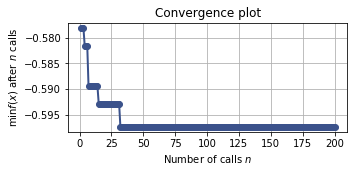

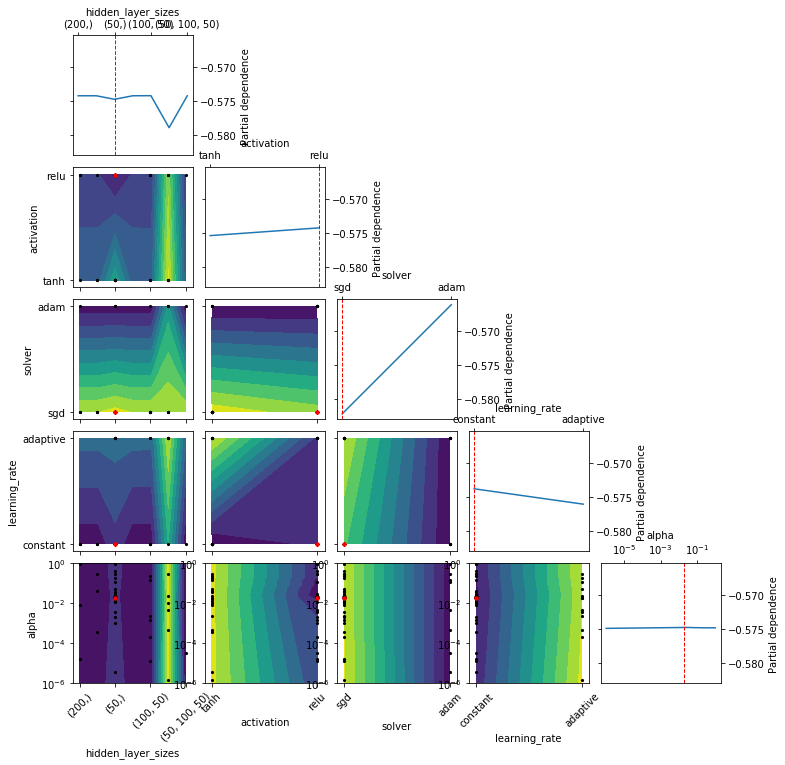

Wall time: 17min


In [19]:
%%time

model = MLPClassifier(max_iter=1000)

dynamic_params_space  = [Categorical([(200,),(100,),(50,),(200,100,),(100,50,),(50,50,50),(50,100,50)], name='hidden_layer_sizes'),
                         Categorical(['tanh', 'relu'], name = 'activation'),
                         Categorical(['sgd', 'adam'], name = 'solver'),
                         Categorical(['constant', 'adaptive'], name = 'learning_rate'),
                         Real(1e-6, 1, prior='log-uniform', name='alpha')]


HPO_params = {'n_calls': 200, 'n_random_starts': 20, 'random_state': 42}
find_best_hyperparameters(model,  X_train, y_train, dynamic_params_space, scoring = 'accuracy', plot = True, **HPO_params)

RandomForestClassifier model training...
Optimized parameters:     ['n_estimators', 'max_depth', 'criterion', 'min_samples_split', 'class_weight']
Previous best parameters: None
Current  best parameters: [319, 18, 'entropy', 2, 'balanced']
Best score: 0.6490509744175712


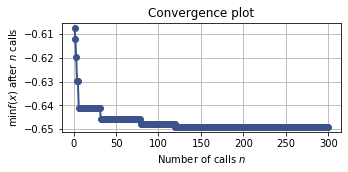

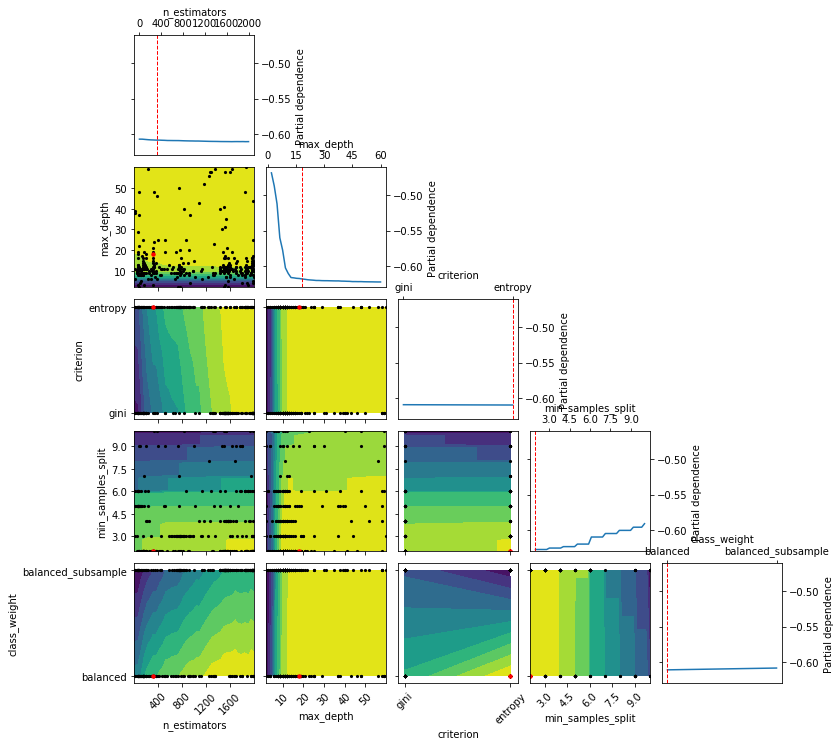

Wall time: 22min 55s


In [66]:
%%time

model = RandomForestClassifier()

dynamic_params_space  = [Integer(2,2000, name='n_estimators'),
                         Integer(2,60, name='max_depth'),
                         Categorical(['gini', 'entropy'], name = 'criterion'),
                         Integer(2,10, name='min_samples_split'),
                         Categorical(['balanced', 'balanced_subsample'], name = 'class_weight')]
                         
HPO_params = {'n_calls': 300, 'n_random_starts': 30, 'random_state': 42}
find_best_hyperparameters(model,  X_train, y_train, dynamic_params_space, scoring = 'accuracy', plot = True, **HPO_params)

ExtraTreesClassifier model training...
Optimized parameters:     ['n_estimators', 'max_depth', 'criterion', 'min_samples_split', 'class_weight']
Previous best parameters: [1109, 17, 'gini', 2, 'balanced']
Current  best parameters: [158, 18, 'entropy', 3, 'balanced']
Best score: 0.6524281089316321


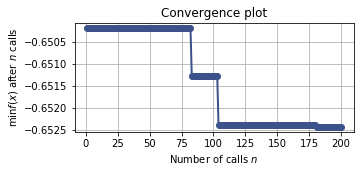

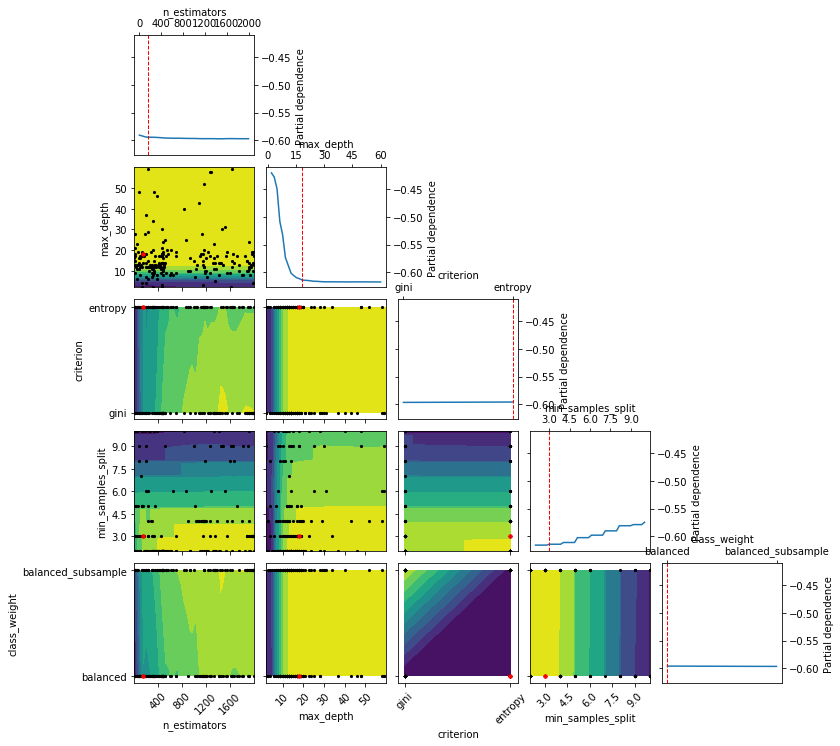

Wall time: 7min 26s


In [21]:
%%time

model = ExtraTreesClassifier()

dynamic_params_space  = [Integer(2,2000, name='n_estimators'),
                         Integer(2,60, name='max_depth'),
                         Categorical(['gini', 'entropy'], name = 'criterion'),
                         Integer(2,10, name='min_samples_split'),
                         Categorical(['balanced', 'balanced_subsample'], name = 'class_weight')]
                         
HPO_params = {'n_calls': 200, 'n_random_starts': 20, 'random_state': 42}
find_best_hyperparameters(model,  X_train, y_train, dynamic_params_space, scoring = 'accuracy', plot = True, **HPO_params)

AdaBoostClassifier model training...
Optimized parameters:     ['n_estimators', 'algorithm', 'learning_rate']
Previous best parameters: [447, 'SAMME', 0.07105282257938969]
Current  best parameters: [749, 'SAMME', 0.03752528339573978]
Best score: 0.5703421570494509


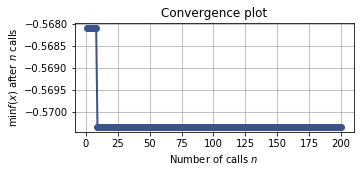

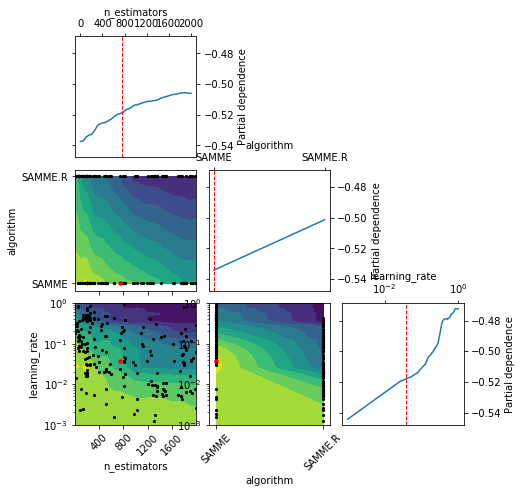

Wall time: 7min 26s


In [22]:
%%time

model = AdaBoostClassifier()

dynamic_params_space  = [Integer(2,2000, name='n_estimators'),
                         Categorical(['SAMME', 'SAMME.R'], name = 'algorithm'),
                         Real(1e-3, 1, prior='log-uniform', name='learning_rate')]

                         
HPO_params = {'n_calls': 200, 'n_random_starts': 20, 'random_state': 42}
find_best_hyperparameters(model,  X_train, y_train, dynamic_params_space, scoring = 'accuracy', plot = True, **HPO_params)

GradientBoostingClassifier model training...
Optimized parameters:     ['n_estimators', 'max_depth', 'min_samples_split', 'learning_rate']
Previous best parameters: [1470, 11, 6, 0.06160322899546776]
Current  best parameters: [1470, 11, 6, 0.06160322899546776]
Best score: 0.6366660318669459


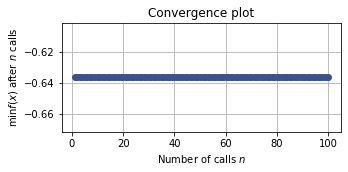

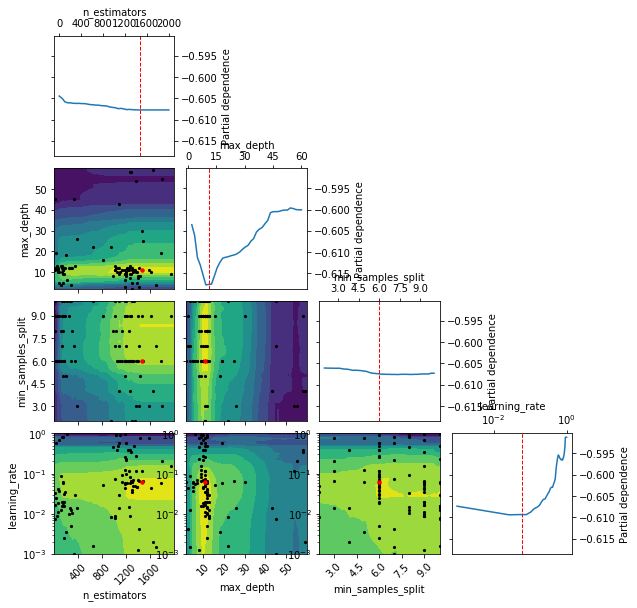

Wall time: 23min 31s


In [23]:
%%time

model = GradientBoostingClassifier()

dynamic_params_space  = [Integer(2,2000, name='n_estimators'),
                         Integer(2,60, name='max_depth'),
                         Integer(2,10, name='min_samples_split'),
                         Real(1e-3, 1, prior='log-uniform', name='learning_rate')]
                         
HPO_params = {'n_calls': 100, 'n_random_starts': 20, 'random_state': 42}
find_best_hyperparameters(model,  X_train, y_train, dynamic_params_space, scoring = 'accuracy', plot = True, **HPO_params)

LGBMClassifier model training...
Optimized parameters:     ['num_leaves', 'max_depth', 'min_data_in_leaf', 'max_bin', 'learning_rate']
Previous best parameters: [962, 22, 95, 522, 0.06838478430964046]
Current  best parameters: [581, 90, 91, 81, 0.06582047139001672]
Best score: 0.6062972132292261


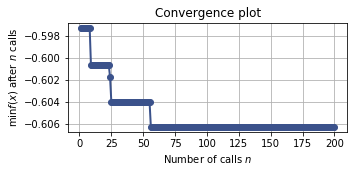

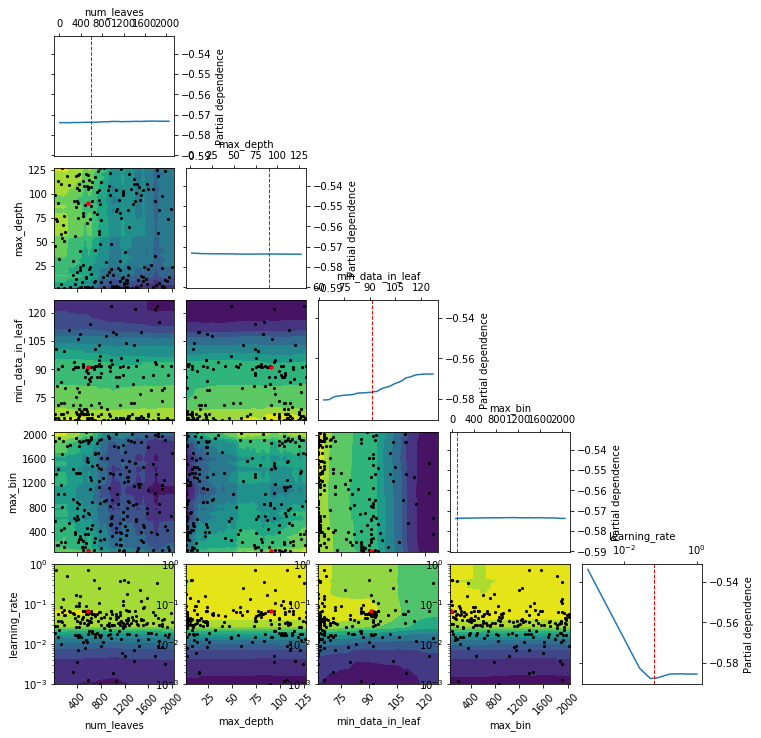

Wall time: 3min 23s


In [24]:
%%time
model = LGBMClassifier()

dynamic_params_space  = [Integer(7, 2047, name='num_leaves'),
                         Integer(2, 127, name='max_depth'),
                         Integer(63, 127, name='min_data_in_leaf'),
                         Integer(63, 2047, name='max_bin'),
                         Real(1e-3, 1, prior='log-uniform', name='learning_rate')]

HPO_params = {'n_calls': 200, 'n_random_starts': 20, 'random_state': 42}

find_best_hyperparameters(model,  X_train, y_train, dynamic_params_space, scoring = 'accuracy', plot = True, **HPO_params)

## Compare Classifiers after Parameters Optimization

In [29]:
compare_classifiers(classifiers, X_train, y_train, X_test, y_test, n_splits=5, load_best_params=True, show_predicts=False)

DummyClassifier parameters were not previously optimized
LogisticRegression optimized parameters: {'C': 0.07052965402859755}
GaussianProcessClassifier parameters were not previously optimized
SVC optimized parameters: {'C': 1.6237306762366168, 'gamma': 1.1766027095650582}
KNeighborsClassifier optimized parameters: {'n_neighbors': 52, 'weights': 'distance', 'p': 3}
MLPClassifier optimized parameters: {'hidden_layer_sizes': (50,), 'activation': 'relu', 'solver': 'sgd', 'learning_rate': 'constant', 'alpha': 0.0186351982594033}


Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.


RandomForestClassifier optimized parameters: {'n_estimators': 438, 'max_depth': 12, 'criterion': 'entropy', 'min_samples_split': 3, 'class_weight': 'balanced_subsample'}
ExtraTreesClassifier optimized parameters: {'n_estimators': 158, 'max_depth': 18, 'criterion': 'entropy', 'min_samples_split': 3, 'class_weight': 'balanced'}
AdaBoostClassifier optimized parameters: {'n_estimators': 749, 'algorithm': 'SAMME', 'learning_rate': 0.03752528339573978}
GradientBoostingClassifier optimized parameters: {'n_estimators': 1470, 'max_depth': 11, 'min_samples_split': 6, 'learning_rate': 0.06160322899546776}
LGBMClassifier optimized parameters: {'num_leaves': 581, 'max_depth': 90, 'min_data_in_leaf': 91, 'max_bin': 81, 'learning_rate': 0.06582047139001672}


,model,train_score,val_score,test_score,fit_time
0,KNeighborsClassifier,1.000000,0.632210,0.680282,0.002578
1,RandomForestClassifier,1.000000,0.638920,0.676056,1.975607
2,ExtraTreesClassifier,1.000000,0.640030,0.656338,0.347799
3,GradientBoostingClassifier,1.000000,0.623164,0.642254,12.093843
4,LGBMClassifier,0.731998,0.606297,0.635211,0.227879
5,GaussianProcessClassifier,0.670417,0.586034,0.616901,78.952298
6,SVC,0.990158,0.626522,0.615493,0.053114
7,AdaBoostClassifier,0.590271,0.570342,0.608451,1.648173
8,LogisticRegression,0.586895,0.583806,0.605634,0.026626
9,MLPClassifier,0.647078,0.592852,0.597183,4.171697


## Feature Importance

LGBMClassifier optimized parameters: {'num_leaves': 581, 'max_depth': 90, 'min_data_in_leaf': 91, 'max_bin': 81, 'learning_rate': 0.06582047139001672}


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


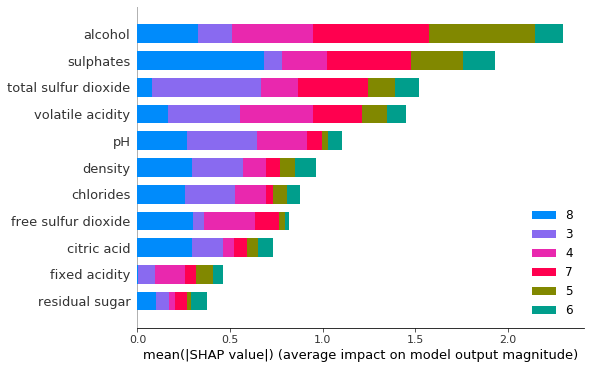

In [30]:
model = LGBMClassifier()

plot_shap_feature_importance(model, X_train, y_train)

## Ensemble

### Ensemble models
- Meta KFold scheme with OOF meta-features is used:
1. Lets say we have N diverse models with optimized hyperparameters
- for model in models:  
    get best hyperparameters for this model from file  
    using cross-validation calculate train predictions  
    y_train_predict = cross_val_predict(model, X_train, y_train, cv, seed = 42)  
    retrain the model using whole train set  
    model.fit(X_train,y_train)       
    predict for test set  
    y_test_predict = model.predict(X_test)  
Thus we obtained 
model_train_predict = (n_train_samples X n_models)
model_test_predict (n_test_samples X n_models).

2.
- Use KFold scheme on model_train_predict to validate hyperparameters for meta-model (e.g. lr). A common practice to fix seed for this KFold to be the same as seed for KFold used to get OOF predictions.
- When the meta-model is validated, fit it to train_meta and predict for test_meta.

In [32]:
classifiers = [LogisticRegression(max_iter=10000),                             
               GaussianProcessClassifier(1.0 * RBF(1.0)),               
               SVC(kernel="rbf"),    
               KNeighborsClassifier(),               
               MLPClassifier(max_iter=1000),               
               RandomForestClassifier(),
               ExtraTreesClassifier(),
               AdaBoostClassifier(),
               GradientBoostingClassifier(),
               LGBMClassifier()]

for model in classifiers:
    get_train_test_predicts(model, X_train, y_train, X_test, y_test, seed)

LogisticRegression
LogisticRegression optimized parameters: {'C': 0.07052965402859755}
train mse: 0.49718785151856015
test mse: 0.5577464788732395
Model predicts saved in file output/predicts/1st_level_classifiers_train_predicts.csv
Model predicts saved in file output/predicts/1st_level_classifiers_test_predicts.csv
GaussianProcessClassifier
GaussianProcessClassifier parameters were not previously optimized
train mse: 0.5106861642294713
test mse: 0.5591549295774648
Model predicts updated in file output/predicts/1st_level_classifiers_train_predicts.csv
Model predicts updated in file output/predicts/1st_level_classifiers_test_predicts.csv
SVC
SVC optimized parameters: {'C': 1.6237306762366168, 'gamma': 1.1766027095650582}
train mse: 0.5343082114735658
test mse: 0.7985915492957747
Model predicts updated in file output/predicts/1st_level_classifiers_train_predicts.csv
Model predicts updated in file output/predicts/1st_level_classifiers_test_predicts.csv
KNeighborsClassifier
KNeighborsClass

In [88]:
df_train_meta = pd.read_csv(r'output/predicts/1st_level_classifiers_train_predicts.csv')
df_test_meta = pd.read_csv(r'output/predicts/1st_level_classifiers_test_predicts.csv')

#metamodel = LogisticRegression(max_iter=10000)
metamodel = RandomForestClassifier(max_depth = 2)
#metamodel = KNeighborsClassifier()


metamodel.fit(df_train_meta, y_train)

y_test_predict_meta = metamodel.predict(df_test_meta)
accuracy = accuracy_score(y_test, y_test_predict_meta)
print('Ensemble accuracy:', accuracy)


#importance = metamodel.coef_
#print(importance.shape)
#print(importance.sum(axis=1))
#coord = list(range(len(importance)))
#plt.bar(coord, importance)
#labels = df_train_meta.columns.tolist()
#plt.xticks(coord, labels, rotation=75)
#plt.show()

Ensemble accuracy: 0.6830985915492958


In [48]:
# Compare predicts and true values 
print(y_test.value_counts(), pd.Series(np.round(y_test_predict_meta)).value_counts())

5    305
6    280
7     88
4     24
8      8
3      5
Name: quality, dtype: int64 5    372
6    311
7     27
dtype: int64


In [54]:
print(df_train_meta.shape, y_train.shape)

(889, 10) (889,)


In [89]:
def find_best_hyperparameters_meta(model, X, y, dynamic_params_space, scoring, plot=True, n_splits=5, **HPO_params):
  
    # Get model name
    model_name = model.__class__.__name__
    
    # Get dynamic parameters names: 
    @use_named_args(dynamic_params_space)
    def get_params_names(**dynamic_params):
        return list(dynamic_params.keys())    
    param_names = get_params_names(dynamic_params_space)
        
    # Define an objective function
    @use_named_args(dynamic_params_space)
    def objective(**dynamic_params):
        #model.set_params(**static_params)
        model.set_params(**dynamic_params) 
        pipeline = make_pipeline(scaler, model)
        cv = StratifiedKFold(n_splits=n_splits, random_state=seed, shuffle=True)
        scores = cross_validate(pipeline, X_train, y_train, cv=cv, scoring = scoring, n_jobs=-1)
        val_score = np.mean(scores['test_score'])
        return -val_score

    res = forest_minimize(objective, dynamic_params_space, **HPO_params)
    
    # add attribute - parameters names to the res
    res.param_names = param_names

    print('Optimized parameters:    ', res.param_names)
    print('Current  best parameters:', res.x)
    print('Best score:', -res.fun)
    
    if plot == True:
        plt.figure(figsize=(5,2))
        plot_convergence(res)
        try:
            # plot_objective would not work if only one parameter was searched for
            plot_objective(res)
        except:
            pass
    plt.show()
    
    param_names = res.param_names
    param_values = res.x
    best_pparameters_dict = dict(zip(param_names, param_values))    
    model.set_params()
    return model

The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.


Optimized parameters:     ['n_estimators', 'max_depth', 'criterion', 'min_samples_split', 'class_weight']
Current  best parameters: [97, 3, 'gini', 2, 'balanced']
Best score: 0.4690535136164541


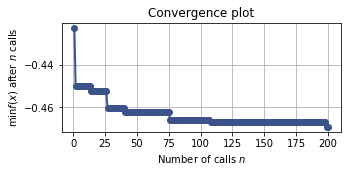

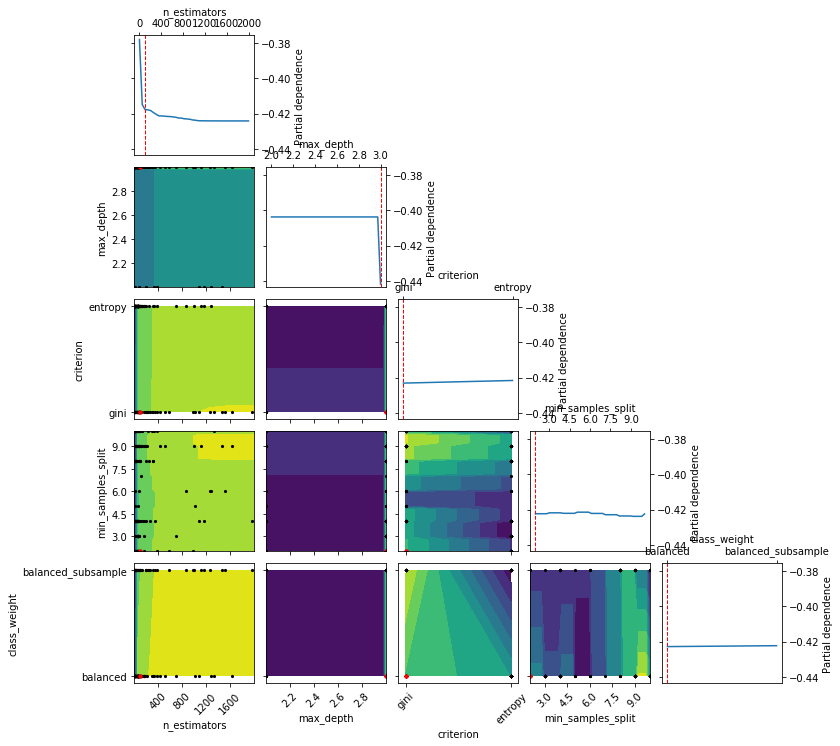

Wall time: 3min 26s


In [92]:
%%time
metamodel = RandomForestClassifier()

dynamic_params_space  = [Integer(2,2000, name='n_estimators'),
                         Integer(2,3, name='max_depth'),
                         Categorical(['gini', 'entropy'], name = 'criterion'),
                         Integer(2,10, name='min_samples_split'),
                         Categorical(['balanced', 'balanced_subsample'], name = 'class_weight')]
                         
HPO_params = {'n_calls': 200, 'n_random_starts': 20, 'random_state': 42}

optimized_metamodel = find_best_hyperparameters_meta(metamodel, df_train_meta, y_train, dynamic_params_space, scoring = 'accuracy', plot = True, **HPO_params)

In [69]:
optimized_metamodel.fit(df_train_meta, y_train)
metamodel_predicts = optimized_metamodel.predict(df_test_meta)
print(accuracy_score(metamodel_predicts, y_test))

0.6352112676056338


In [70]:
metamodel = RandomForestClassifier()
metamodel.fit(df_train_meta, y_train)
metamodel_predicts = metamodel.predict(df_test_meta)
print(accuracy_score(metamodel_predicts, y_test))

0.6169014084507042
